# Training-VOC-dataset-SVHN

## Introduction

Object detection is the process of identifying and localizing objects in an image. A typical object detection solution takes in an image as input and provides a bounding box on the image where a object of interest is along with identifying what object the box encapsulates. But before we have this solution, we need to acquire and process a traning dataset, create and setup a training job for the alorithm so that the aglorithm can learn about the dataset and then host the algorithm as an endpoint, to which we can supply the query image.

This notebook is an end-to-end example introducing the Amazon SageMaker Object Detection algorithm. In this demo, we will demonstrate how to train and to host an object detection model on the [Pascal VOC dataset](http://host.robots.ox.ac.uk/pascal/VOC/) using the Single Shot multibox Detector ([SSD](https://arxiv.org/abs/1512.02325)) algorithm. <br>

In doing so, we will also demonstrate how to construct a training dataset using the RecordIO format as this is the format that the training job will consume. We will also demonstrate how to host and validate this trained model. Amazon SageMaker Object Detection also allow training with the image and JSON format, which is illustrated in the [image and JSON Notebook](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/object_detection_pascalvoc_coco/object_detection_image_json_format.ipynb).

The objective is to train an object detection model for number detection using SageMaker Object Detection on the RecordIO format

### Base Network

The training output will be used as a base model for incremental training, SHVN dataset are relatively more balanced and larger than other datasets we prepared, therefore the model trained using SHVN is assumed to have better performance as a base model

### Data Preparation

In [15]:
pip install mxnet

Note: you may need to restart the kernel to use updated packages.


### Convert data into RecordIO
[RecordIO](https://mxnet.incubator.apache.org/architecture/note_data_loading.html) is a highly efficient binary data format from [MXNet](https://mxnet.incubator.apache.org/) that makes it easy and simple to prepare the dataset and transfer to the instance that will run the training job. To generate a RecordIO file, we will use the tools from MXNet. The provided tools will first generate a list file and then use the [im2rec tool](https://github.com/apache/incubator-mxnet/blob/master/tools/im2rec.py) to create the [RecordIO](https://mxnet.incubator.apache.org/architecture/note_data_loading.html) file. More details on how to generate RecordIO file for object detection task, see the [MXNet example](https://github.com/apache/incubator-mxnet/tree/master/example/ssd).

We will combine 2015(SVHN test set) training set as the training data set, and use the validation set as our validation set.

In [16]:
%%time

# 2015 (SVHN test) train split
!python tools/prepare_dataset.py --dataset pascal --year 2015 --set train --target VOCdevkit/train.lst

# 2015 (SVHN test) val split
!python tools/prepare_dataset.py --dataset pascal --year 2015 --set val --target VOCdevkit/val.lst --no-shuffle

saving list to disk...
List file VOCdevkit/train.lst generated...
Creating .rec file from /home/ec2-user/SageMaker/VOCdevkit/train.lst in /home/ec2-user/SageMaker/VOCdevkit
time: 0.5391361713409424  count: 0
time: 1.910315990447998  count: 1000
time: 0.6328022480010986  count: 2000
time: 0.6217248439788818  count: 3000
time: 0.5991744995117188  count: 4000
time: 0.5663118362426758  count: 5000
time: 0.5966503620147705  count: 6000
time: 0.5898444652557373  count: 7000
total count:
7840
Record file VOCdevkit/train.rec generated...
saving list to disk...
List file VOCdevkit/val.lst generated...
Creating .rec file from /home/ec2-user/SageMaker/VOCdevkit/val.lst in /home/ec2-user/SageMaker/VOCdevkit
time: 0.005342960357666016  count: 0
time: 0.6495044231414795  count: 1000
time: 0.6050307750701904  count: 2000
time: 0.5745267868041992  count: 3000
time: 0.6515288352966309  count: 4000
time: 0.5519204139709473  count: 5000
total count:
5228
Record file VOCdevkit/val.rec generated...
CPU tim

In [12]:
training_sample_no = 7840

### Understanding RecodIO format

Along with this notebook, we have provided tools that can directly generated the RecordIO files so that you do not need to do addtional work. These tools work with the Pascal datasets lst format, which is also quite the common among most datasets. If your data are stored in a different format or the annotation of your data is in a different format than the Pascal VOC dataset, you can also create the RecordIO by first generating the .lst file and then using the im2rec tool provided by MXNet. To make things clear, we will explain the definition of a .lst file so that you can prepare it in your own way. The following example is the first three lines of the .lst file we just generated for the Pascal VOC dataset.

In [3]:
!head -n 3 VOCdevkit/train.lst > example.lst
f = open('example.lst','r')
lst_content = f.read()
print(lst_content)

0	2	5	4.0000	0.4571	0.2447	0.6571	0.3936	VOC2007/JPEGImages/2925_16_orginal.jpg
1	2	5	9.0000	0.5000	0.2432	0.7308	0.3919	VOC2007/JPEGImages/8233_21_orginal.jpg
2	2	5	1.0000	0.5789	0.1961	0.7105	0.3333	VOC2007/JPEGImages/19.jpg



As can be seen that each line in the .lst file represents the annotations for a image. A .lst file is a tab-delimited file with multiple columns. The rows of the file are annotations of the of image files. The first column specifies a unique image index. The second column specifies the header size of the current row. In the above example .lst file, 2 from the second column means the second and third columns are header information, which will not be considered as label and bounding box information of the image specified by the current row.

The third column specifies the label width of a single object. In the first row of above sample .lst file, 5 from the third row means each object within an image will have 5 numbers to describe its label information, including class index, and bounding box coordinates. If there are multiple objects within one image, all the label information should be listed in one line. The annotation information for each object is represented as [class_index, xmin, ymin, xmax, ymax].

The classes should be labeled with successive numbers and start with 0. The bounding box coordinates are ratios of its top-left (xmin, ymin) and bottom-right (xmax, ymax) corner indices to the overall image size. Note that the top-left corner of the entire image is the origin (0, 0). The last column specifies the relative path of the image file.

## Setup

To train the Object Detection algorithm on Amazon SageMaker, we need to setup and authenticate the use of AWS services. To begin with we need an AWS account role with SageMaker access. This role is used to give SageMaker access to your data in S3 will automatically be obtained from the role used to start the notebook.

In [5]:
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
print(role)
sess = sagemaker.Session()

arn:aws:iam::874960312361:role/service-role/AmazonSageMaker-ExecutionRole-20210809T140402


We also need the S3 bucket that you want to use for training and to store the tranied model artifacts. In this notebook, we require a custom bucket that exists so as to keep the naming clean. You can end up using a default bucket that SageMaker comes with as well.

In [6]:
training_bucket = 'number-detection-pascal-0816' # custom bucket name.
no_detection_train_prefix = 'NumberDetection0921'

Lastly, we need the Amazon SageMaker Object Detection docker image, which is static and need not be changed.

In [7]:
from sagemaker.amazon.amazon_estimator import get_image_uri

training_image = get_image_uri(sess.boto_region_name, 'object-detection', repo_version="latest")
print (training_image)

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


644912444149.dkr.ecr.eu-west-2.amazonaws.com/object-detection:1


### Upload data to S3

Upload the data to the S3 bucket. We do this in multiple channels. Channels are simply directories in the bucket that differentiate between training and validation data. Let us simply call these directories train and validation.

In [8]:
%%time

# Upload the RecordIO files to train and validation channels
train_channel = no_detection_train_prefix + '/train'
validation_channel = no_detection_train_prefix + '/validation'

sess.upload_data(path='VOCdevkit/train.rec', bucket=training_bucket, key_prefix=train_channel)
sess.upload_data(path='VOCdevkit/val.rec', bucket=training_bucket, key_prefix=validation_channel)

s3_train_data = 's3://{}/{}'.format(training_bucket, train_channel)
s3_validation_data = 's3://{}/{}'.format(training_bucket, validation_channel)

print(s3_train_data)
print(s3_validation_data)

s3://number-detection-pascal-0816/NumberDetection0921/train
s3://number-detection-pascal-0816/NumberDetection0921/validation
CPU times: user 789 ms, sys: 220 ms, total: 1.01 s
Wall time: 2.59 s


Next we need to setup an output location at S3, where the model artifact will be dumped. These artifacts are also the output of the algorithm's traning job.

In [9]:
s3_number_output_location = 's3://{}/{}/output'.format(training_bucket, no_detection_train_prefix)

print(s3_number_output_location)

s3://number-detection-pascal-0816/NumberDetection0921/output


### Tuning Hyperparameter 

Normally, in AWS machine learning, tuning hyperparameters means runing parallel training jobs at the same time, then select the bset performing training job from all tuning outputs. However, to save time from waiting for multiples training jobs to complete, we will create an seperate esitimator just for a short tuning epochs to get the best performimg hyperparameters' value and use them on just one training job.

Set up the estimator for tuning, with the following configuration:

In [24]:
# Esitimator configuration
tune_model = sagemaker.estimator.Estimator(training_image,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.p3.2xlarge',
                                         train_volume_size = 50,
                                         train_max_run = 360000,
                                         input_mode= 'File',
                                         output_path=s3_number_output_location,
                                         sagemaker_session=sess)

# Static Hyperparameters
tune_model.set_hyperparameters(base_network='resnet-50',
                             use_pretrained_model=1,
                             num_classes=10,
                             epochs=5,
                             optimizer='adam',
                             image_shape=300,
                             label_width=350,
                             num_training_samples=training_sample_no)


train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_max_run has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_volume_size has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Next, we set up the tuning job with the following configuration:

- the hyperparameters that SageMaker Automatic Model Tuning will tune: learning_rate, mini_batch_size
- the maximum number of training jobs it will run to optimize the objective metric: 5
- the number of parallel training jobs that will run in the tuning job: 2
- the objective metric that Automatic Model Tuning will use: validation:accuracy

In [25]:
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

# tuner will tune hyperparameter between these range
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.00001, 0.05),
    "mini_batch_size": IntegerParameter(8,64),
}

# tuner will compare results using mAP value
objective_metric_name = "validation:mAP"

tuner = HyperparameterTuner(
    tune_model,
    objective_metric_name,
    hyperparameter_ranges,
    objective_type="Maximize",
    max_jobs=5,
    max_parallel_jobs=2,
)

Launch hyperparameter tuning job

In [ ]:
tuner.fit({"train": s3_train_data, "validation": s3_validation_data}, include_cls_metadata=False)

..........................................................................................................................................................................................................................................................................................................................

Once the tuning job finishes, we can bring in a table of metrics.

In [2]:
# import sagemaker
tuning_job_name = tuner._current_job_name
tuning_job_name = 'object-detection-210921-1202'

tuner_parent_metrics = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name)
if not tuner_parent_metrics.dataframe().empty:
    df_parent = tuner_parent_metrics.dataframe().sort_values(
        ["FinalObjectiveValue"], ascending=False
    )

df_parent

,learning_rate,mini_batch_size,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
2,0.000266,17.0,object-detection-210921-1202-003-7bbe82a0,Completed,0.447436,2021-09-21 12:17:34+00:00,2021-09-21 12:28:55+00:00,681.0
1,0.000275,23.0,object-detection-210921-1202-004-fa6f69b8,Completed,0.431955,2021-09-21 12:18:21+00:00,2021-09-21 12:28:25+00:00,604.0
3,0.001188,43.0,object-detection-210921-1202-002-05a734a0,Completed,0.059695,2021-09-21 12:05:23+00:00,2021-09-21 12:15:24+00:00,601.0
4,0.023003,63.0,object-detection-210921-1202-001-e481c24b,Completed,0.000005,2021-09-21 12:04:58+00:00,2021-09-21 12:14:21+00:00,563.0
0,0.000070,18.0,object-detection-210921-1202-005-1fa764de,Stopped,NaN,2021-09-21 12:33:06+00:00,2021-09-21 12:35:20+00:00,134.0


### Training

Now that we are done with all the setup that is needed, we are ready to train our object detector. To begin, let us create a sageMaker.estimator.Estimator object. This estimator will launch the training job.

In [10]:
# estimator configuration for training
no_od_model = sagemaker.estimator.Estimator(training_image,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.p3.2xlarge',
                                         train_volume_size = 50,
                                         train_max_run = 360000,
                                         input_mode= 'File',
                                         output_path=s3_number_output_location,
                                         sagemaker_session=sess)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_max_run has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_volume_size has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


The object detection algorithm at its core is the Single-Shot Multi-Box detection algorithm (SSD). This algorithm uses a base_network, which is typically a VGG or a ResNet. The Amazon SageMaker object detection algorithm supports VGG-16 and ResNet-50 now. It also has a lot of options for hyperparameters that help configure the training job. The next step in our training, is to setup these hyperparameters and data channels for training the model.

We will apply the hyperparameters among the best-performed tuning jobs, which are leanring_rate and mini_batch_size, as showed in the table above

In [13]:
# use the best-performed parameters in the tuning session
no_od_model.set_hyperparameters(base_network='resnet-50',
                             use_pretrained_model=1,
                             num_classes=10,
                             mini_batch_size=17,
                             epochs = 60,
                             learning_rate=0.000266,
                             optimizer='adam',
                             image_shape=300,
                             label_width=350,
                             num_training_samples=training_sample_no)

Now that the hyperparameters are setup, let us prepare the handshake between our data channels and the algorithm. To do this, we need to create the sagemaker.session.s3_input objects from our data channels. These objects are then put in a simple dictionary, which the algorithm consumes.

In [14]:
train_data = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', 
                        content_type='application/x-recordio', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3_validation_data, distribution='FullyReplicated', 
                             content_type='application/x-recordio', s3_data_type='S3Prefix')
data_channels = {'train': train_data, 'validation': validation_data}

print(s3_train_data)
print(s3_validation_data)

The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


s3://number-detection-pascal-0816/NumberDetection0921/train
s3://number-detection-pascal-0816/NumberDetection0921/validation


We have our Estimator object, we have set the hyperparameters for this object and we have our data channels linked with the algorithm. The only remaining thing to do is to train the algorithm. The following command will train the algorithm. Training the algorithm involves a few steps. Firstly, the instances that we requested while creating the Estimator classes are provisioned and are setup with the appropriate libraries. Then, the data from our channels are downloaded into the instance. Once this is done, the training job begins. The provisioning and data downloading will take time, depending on the size of the data. Therefore it might be a few minutes before we start getting data logs for our training jobs. The data logs will also print out Mean Average Precision (mAP) on the validation data, among other losses, for every run of the dataset once or one epoch. This metric is a proxy for the quality of the algorithm.

Once the job has finished a "Job complete" message will be printed. The trained model can be found in the S3 bucket that was setup as output_path in the estimator.

In [ ]:
no_od_model.fit(inputs=data_channels, logs=True)

2021-09-22 07:40:47 Starting - Starting the training job...
2021-09-22 07:40:48 Starting - Launching requested ML instancesProfilerReport-1632296446: InProgress
......
2021-09-22 07:41:58 Starting - Preparing the instances for training......
2021-09-22 07:43:13 Downloading - Downloading input data...
2021-09-22 07:43:41 Training - Downloading the training image...
2021-09-22 07:44:15 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
[09/22/2021 07:44:19 INFO 139628256393024] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/default-input.json: {'base_network': 'vgg-16', 'use_pretrained_model': '0', 'num_classes': '', 'mini_batch_size': '32', 'epochs': '30', 'learning_rate': '0.001', 'lr_scheduler_step': '', 'lr_scheduler_factor': '0.1', 'optimizer': 'sgd', 'momentum': '0.9', 'weight_decay': '0.0005', 'overlap_threshold': '0.5', 'nms_threshold': '0.45', 'num_training_samples': '', 'imag

[09/22/2021 07:47:06 INFO 139628256393024] Epoch:    1, batches:    100, num_examples:   1700, 107.9 samples/sec, epoch time so far:  0:00:15.762032
[09/22/2021 07:47:21 INFO 139628256393024] Epoch:    1, batches:    200, num_examples:   3400, 109.9 samples/sec, epoch time so far:  0:00:30.947412
[09/22/2021 07:47:36 INFO 139628256393024] Epoch:    1, batches:    300, num_examples:   5100, 110.8 samples/sec, epoch time so far:  0:00:46.040378
[09/22/2021 07:47:52 INFO 139628256393024] Epoch:    1, batches:    400, num_examples:   6800, 111.2 samples/sec, epoch time so far:  0:01:01.158479
[09/22/2021 07:48:01 INFO 139628256393024] #quality_metric: host=algo-1, epoch=1, batch=461 train cross_entropy <loss>=(0.9789996276814714)
[09/22/2021 07:48:01 INFO 139628256393024] #quality_metric: host=algo-1, epoch=1, batch=461 train smooth_l1 <loss>=(0.4049153794041947)
[09/22/2021 07:48:01 INFO 139628256393024] Round of batches complete
[09/22/2021 07:48:02 INFO 139628256393024] Updated the metr

[09/22/2021 07:54:24 INFO 139628256393024] Epoch:    5, batches:    100, num_examples:   1700, 111.6 samples/sec, epoch time so far:  0:00:15.234941
[09/22/2021 07:54:40 INFO 139628256393024] Epoch:    5, batches:    200, num_examples:   3400, 112.2 samples/sec, epoch time so far:  0:00:30.300668
[09/22/2021 07:54:55 INFO 139628256393024] Epoch:    5, batches:    300, num_examples:   5100, 112.3 samples/sec, epoch time so far:  0:00:45.404035
[09/22/2021 07:55:10 INFO 139628256393024] Epoch:    5, batches:    400, num_examples:   6800, 111.7 samples/sec, epoch time so far:  0:01:00.861580
[09/22/2021 07:55:20 INFO 139628256393024] #quality_metric: host=algo-1, epoch=5, batch=462 train cross_entropy <loss>=(0.7670196575193263)
[09/22/2021 07:55:20 INFO 139628256393024] #quality_metric: host=algo-1, epoch=5, batch=462 train smooth_l1 <loss>=(0.33020814333389054)
[09/22/2021 07:55:20 INFO 139628256393024] Round of batches complete
[09/22/2021 07:55:20 INFO 139628256393024] Updated the met

[09/22/2021 08:01:26 INFO 139628256393024] Epoch:    9, batches:    100, num_examples:   1700, 112.3 samples/sec, epoch time so far:  0:00:15.135574
[09/22/2021 08:01:41 INFO 139628256393024] Epoch:    9, batches:    200, num_examples:   3400, 112.6 samples/sec, epoch time so far:  0:00:30.196381
[09/22/2021 08:01:56 INFO 139628256393024] Epoch:    9, batches:    300, num_examples:   5100, 112.7 samples/sec, epoch time so far:  0:00:45.250352
[09/22/2021 08:02:12 INFO 139628256393024] Epoch:    9, batches:    400, num_examples:   6800, 112.0 samples/sec, epoch time so far:  0:01:00.721205
[09/22/2021 08:02:22 INFO 139628256393024] #quality_metric: host=algo-1, epoch=9, batch=461 train cross_entropy <loss>=(0.6918983028231059)
[09/22/2021 08:02:22 INFO 139628256393024] #quality_metric: host=algo-1, epoch=9, batch=461 train smooth_l1 <loss>=(0.3126381193768617)
[09/22/2021 08:02:22 INFO 139628256393024] Round of batches complete
[09/22/2021 08:02:22 INFO 139628256393024] Updated the metr

[09/22/2021 08:08:18 INFO 139628256393024] Epoch:    13, batches:    100, num_examples:   1700, 108.3 samples/sec, epoch time so far:  0:00:15.694250
[09/22/2021 08:08:34 INFO 139628256393024] Epoch:    13, batches:    200, num_examples:   3400, 110.5 samples/sec, epoch time so far:  0:00:30.774299
[09/22/2021 08:08:49 INFO 139628256393024] Epoch:    13, batches:    300, num_examples:   5100, 111.2 samples/sec, epoch time so far:  0:00:45.866571
[09/22/2021 08:09:04 INFO 139628256393024] Epoch:    13, batches:    400, num_examples:   6800, 111.4 samples/sec, epoch time so far:  0:01:01.044763
[09/22/2021 08:09:14 INFO 139628256393024] #quality_metric: host=algo-1, epoch=13, batch=461 train cross_entropy <loss>=(0.6521893010645207)
[09/22/2021 08:09:14 INFO 139628256393024] #quality_metric: host=algo-1, epoch=13, batch=461 train smooth_l1 <loss>=(0.29739796341537555)
[09/22/2021 08:09:14 INFO 139628256393024] Round of batches complete
[09/22/2021 08:09:14 INFO 139628256393024] Updated t

[09/22/2021 08:15:10 INFO 139628256393024] Epoch:    17, batches:    100, num_examples:   1700, 86.9 samples/sec, epoch time so far:  0:00:19.554919
[09/22/2021 08:15:25 INFO 139628256393024] Epoch:    17, batches:    200, num_examples:   3400, 98.2 samples/sec, epoch time so far:  0:00:34.614736
[09/22/2021 08:15:40 INFO 139628256393024] Epoch:    17, batches:    300, num_examples:   5100, 102.7 samples/sec, epoch time so far:  0:00:49.679191
[09/22/2021 08:15:55 INFO 139628256393024] Epoch:    17, batches:    400, num_examples:   6800, 105.0 samples/sec, epoch time so far:  0:01:04.743617
[09/22/2021 08:16:05 INFO 139628256393024] #quality_metric: host=algo-1, epoch=17, batch=462 train cross_entropy <loss>=(0.6355475246089165)
[09/22/2021 08:16:05 INFO 139628256393024] #quality_metric: host=algo-1, epoch=17, batch=462 train smooth_l1 <loss>=(0.29897978822949905)
[09/22/2021 08:16:05 INFO 139628256393024] Round of batches complete
[09/22/2021 08:16:05 INFO 139628256393024] Updated the

[09/22/2021 08:22:01 INFO 139628256393024] Epoch:    21, batches:    100, num_examples:   1700, 112.1 samples/sec, epoch time so far:  0:00:15.159619
[09/22/2021 08:22:16 INFO 139628256393024] Epoch:    21, batches:    200, num_examples:   3400, 111.3 samples/sec, epoch time so far:  0:00:30.555176
[09/22/2021 08:22:32 INFO 139628256393024] Epoch:    21, batches:    300, num_examples:   5100, 111.5 samples/sec, epoch time so far:  0:00:45.756353
[09/22/2021 08:22:47 INFO 139628256393024] Epoch:    21, batches:    400, num_examples:   6800, 111.6 samples/sec, epoch time so far:  0:01:00.932666
[09/22/2021 08:22:56 INFO 139628256393024] #quality_metric: host=algo-1, epoch=21, batch=461 train cross_entropy <loss>=(0.609474047225195)
[09/22/2021 08:22:56 INFO 139628256393024] #quality_metric: host=algo-1, epoch=21, batch=461 train smooth_l1 <loss>=(0.28639588642221037)
[09/22/2021 08:22:56 INFO 139628256393024] Round of batches complete
[09/22/2021 08:22:57 INFO 139628256393024] Updated th

[09/22/2021 08:28:48 INFO 139628256393024] Epoch:    25, batches:    100, num_examples:   1700, 111.5 samples/sec, epoch time so far:  0:00:15.247222
[09/22/2021 08:29:03 INFO 139628256393024] Epoch:    25, batches:    200, num_examples:   3400, 112.3 samples/sec, epoch time so far:  0:00:30.286236
[09/22/2021 08:29:19 INFO 139628256393024] Epoch:    25, batches:    300, num_examples:   5100, 111.9 samples/sec, epoch time so far:  0:00:45.594263
[09/22/2021 08:29:34 INFO 139628256393024] Epoch:    25, batches:    400, num_examples:   6800, 112.1 samples/sec, epoch time so far:  0:01:00.656366
[09/22/2021 08:29:44 INFO 139628256393024] #quality_metric: host=algo-1, epoch=25, batch=461 train cross_entropy <loss>=(0.5955251408681903)
[09/22/2021 08:29:44 INFO 139628256393024] #quality_metric: host=algo-1, epoch=25, batch=461 train smooth_l1 <loss>=(0.27922341532814854)
[09/22/2021 08:29:44 INFO 139628256393024] Round of batches complete
[09/22/2021 08:29:44 INFO 139628256393024] Updated t

[09/22/2021 08:35:30 INFO 139628256393024] Epoch:    29, batches:    100, num_examples:   1700, 110.4 samples/sec, epoch time so far:  0:00:15.396518
[09/22/2021 08:35:46 INFO 139628256393024] Epoch:    29, batches:    200, num_examples:   3400, 111.4 samples/sec, epoch time so far:  0:00:30.517851
[09/22/2021 08:36:01 INFO 139628256393024] Epoch:    29, batches:    300, num_examples:   5100, 111.8 samples/sec, epoch time so far:  0:00:45.623907
[09/22/2021 08:36:16 INFO 139628256393024] Epoch:    29, batches:    400, num_examples:   6800, 111.3 samples/sec, epoch time so far:  0:01:01.104171
[09/22/2021 08:36:26 INFO 139628256393024] #quality_metric: host=algo-1, epoch=29, batch=461 train cross_entropy <loss>=(0.5831832635679396)
[09/22/2021 08:36:26 INFO 139628256393024] #quality_metric: host=algo-1, epoch=29, batch=461 train smooth_l1 <loss>=(0.27647112698497434)
[09/22/2021 08:36:26 INFO 139628256393024] Round of batches complete
[09/22/2021 08:36:27 INFO 139628256393024] Updated t

[09/22/2021 08:42:13 INFO 139628256393024] Epoch:    33, batches:    100, num_examples:   1700, 109.6 samples/sec, epoch time so far:  0:00:15.504245
[09/22/2021 08:42:28 INFO 139628256393024] Epoch:    33, batches:    200, num_examples:   3400, 110.9 samples/sec, epoch time so far:  0:00:30.666297
[09/22/2021 08:42:44 INFO 139628256393024] Epoch:    33, batches:    300, num_examples:   5100, 111.2 samples/sec, epoch time so far:  0:00:45.880711
[09/22/2021 08:42:59 INFO 139628256393024] Epoch:    33, batches:    400, num_examples:   6800, 111.4 samples/sec, epoch time so far:  0:01:01.029477
[09/22/2021 08:43:08 INFO 139628256393024] #quality_metric: host=algo-1, epoch=33, batch=461 train cross_entropy <loss>=(0.5744855702378775)
[09/22/2021 08:43:08 INFO 139628256393024] #quality_metric: host=algo-1, epoch=33, batch=461 train smooth_l1 <loss>=(0.27385757930110566)
[09/22/2021 08:43:08 INFO 139628256393024] Round of batches complete
[09/22/2021 08:43:08 INFO 139628256393024] Updated t

[09/22/2021 08:48:56 INFO 139628256393024] Epoch:    37, batches:    100, num_examples:   1700, 110.7 samples/sec, epoch time so far:  0:00:15.353958
[09/22/2021 08:49:12 INFO 139628256393024] Epoch:    37, batches:    200, num_examples:   3400, 110.8 samples/sec, epoch time so far:  0:00:30.698234
[09/22/2021 08:49:27 INFO 139628256393024] Epoch:    37, batches:    300, num_examples:   5100, 111.6 samples/sec, epoch time so far:  0:00:45.699856
[09/22/2021 08:49:42 INFO 139628256393024] Epoch:    37, batches:    400, num_examples:   6800, 112.0 samples/sec, epoch time so far:  0:01:00.693624
[09/22/2021 08:49:51 INFO 139628256393024] #quality_metric: host=algo-1, epoch=37, batch=461 train cross_entropy <loss>=(0.5680908068914691)
[09/22/2021 08:49:51 INFO 139628256393024] #quality_metric: host=algo-1, epoch=37, batch=461 train smooth_l1 <loss>=(0.2653245176739952)
[09/22/2021 08:49:51 INFO 139628256393024] Round of batches complete
[09/22/2021 08:49:52 INFO 139628256393024] Updated th

[09/22/2021 08:58:58 INFO 139628256393024] Epoch:    43, batches:    100, num_examples:   1700, 110.8 samples/sec, epoch time so far:  0:00:15.345713
[09/22/2021 08:59:14 INFO 139628256393024] Epoch:    43, batches:    200, num_examples:   3400, 110.2 samples/sec, epoch time so far:  0:00:30.846449
[09/22/2021 08:59:29 INFO 139628256393024] Epoch:    43, batches:    300, num_examples:   5100, 110.9 samples/sec, epoch time so far:  0:00:45.973979
[09/22/2021 08:59:44 INFO 139628256393024] Epoch:    43, batches:    400, num_examples:   6800, 111.6 samples/sec, epoch time so far:  0:01:00.933354
[09/22/2021 08:59:53 INFO 139628256393024] #quality_metric: host=algo-1, epoch=43, batch=461 train cross_entropy <loss>=(0.5581192489896097)
[09/22/2021 08:59:53 INFO 139628256393024] #quality_metric: host=algo-1, epoch=43, batch=461 train smooth_l1 <loss>=(0.26395475970689114)
[09/22/2021 08:59:53 INFO 139628256393024] Round of batches complete
[09/22/2021 08:59:54 INFO 139628256393024] Updated t

[09/22/2021 09:05:38 INFO 139628256393024] Epoch:    47, batches:    100, num_examples:   1700, 111.1 samples/sec, epoch time so far:  0:00:15.300204
[09/22/2021 09:05:53 INFO 139628256393024] Epoch:    47, batches:    200, num_examples:   3400, 111.8 samples/sec, epoch time so far:  0:00:30.414567
[09/22/2021 09:06:09 INFO 139628256393024] Epoch:    47, batches:    300, num_examples:   5100, 111.0 samples/sec, epoch time so far:  0:00:45.952077
[09/22/2021 09:06:24 INFO 139628256393024] Epoch:    47, batches:    400, num_examples:   6800, 111.5 samples/sec, epoch time so far:  0:01:00.960480
[09/22/2021 09:06:34 INFO 139628256393024] #quality_metric: host=algo-1, epoch=47, batch=461 train cross_entropy <loss>=(0.554076391402577)
[09/22/2021 09:06:34 INFO 139628256393024] #quality_metric: host=algo-1, epoch=47, batch=461 train smooth_l1 <loss>=(0.26193442469281064)
[09/22/2021 09:06:34 INFO 139628256393024] Round of batches complete
[09/22/2021 09:06:34 INFO 139628256393024] Updated th

In [3]:
no_od_model.logs()

2021-09-22 09:27:47 Starting - Preparing the instances for training
2021-09-22 09:27:47 Downloading - Downloading input data
2021-09-22 09:27:47 Training - Training image download completed. Training in progress.
2021-09-22 09:27:47 Uploading - Uploading generated training model
2021-09-22 09:27:47 Completed - Training job completedDocker entrypoint called with argument(s): train
[09/22/2021 07:44:19 INFO 139628256393024] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/default-input.json: {'base_network': 'vgg-16', 'use_pretrained_model': '0', 'num_classes': '', 'mini_batch_size': '32', 'epochs': '30', 'learning_rate': '0.001', 'lr_scheduler_step': '', 'lr_scheduler_factor': '0.1', 'optimizer': 'sgd', 'momentum': '0.9', 'weight_decay': '0.0005', 'overlap_threshold': '0.5', 'nms_threshold': '0.45', 'num_training_samples': '', 'image_shape': '300', '_tuning_objective_metric': '', '_kvstore': 'device', 'kv_store': 'device', '_num_kv_servers': 'auto', '

### Visualise Training logs

In [4]:
import boto3
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline

client = boto3.client("logs")
BASE_LOG_NAME = "/aws/sagemaker/TrainingJobs"


def plot_object_detection_log_map(model, title):
    logs = client.describe_log_streams(
        logGroupName=BASE_LOG_NAME, logStreamNamePrefix=model._current_job_name
    )
    cw_log = client.get_log_events(
        logGroupName=BASE_LOG_NAME, logStreamName=logs["logStreams"][0]["logStreamName"]
    )

    mAP_accs = []
    for e in cw_log["events"]:
        msg = e["message"]
        if "validation mAP <score>=" in msg:
            num_start = msg.find("(")
            num_end = msg.find(")")
            mAP = msg[num_start + 1 : num_end]
            mAP_accs.append(float(mAP))

    print(title)
    print("Maximum mAP: %f " % max(mAP_accs))

    fig, ax = plt.subplots()
    plt.xlabel("Epochs")
    plt.ylabel("Mean Avg Precision (mAP)")
    (val_plot,) = ax.plot(range(len(mAP_accs)), mAP_accs, label="mAP")
    plt.legend(handles=[val_plot])
    ax.yaxis.set_ticks(np.arange(0.0, 1.05, 0.1))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%0.2f"))
    plt.show()

mAP tracking for job: object-detection-2021-09-22-07-40-46-799
Maximum mAP: 0.706078 


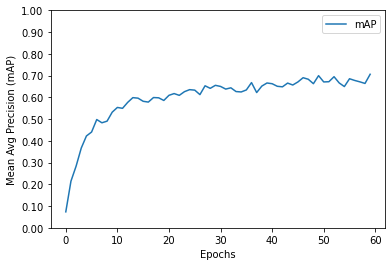

In [5]:
plot_object_detection_log_map(no_od_model, "mAP tracking for job: " + no_od_model._current_job_name)

In [6]:
import boto3
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline

client = boto3.client("logs")
BASE_LOG_NAME = "/aws/sagemaker/TrainingJobs"


def plot_object_detection_log_loss(model, title):
    logs = client.describe_log_streams(
        logGroupName=BASE_LOG_NAME, logStreamNamePrefix=model._current_job_name
    )
    cw_log = client.get_log_events(
        logGroupName=BASE_LOG_NAME, logStreamName=logs["logStreams"][0]["logStreamName"]
    )

    mAP_accs = []
    for e in cw_log["events"]:
        msg = e["message"]
        if "train smooth_l1 <loss>=" in msg:
            num_start = msg.find("(")
            num_end = msg.find(")")
            mAP = msg[num_start + 1 : num_end]
            mAP_accs.append(float(mAP))

    print(title)
    print("Mnimum loss: %f " % min(mAP_accs))

    fig, ax = plt.subplots()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    (val_plot,) = ax.plot(range(len(mAP_accs)), mAP_accs, label="Loss")
    plt.legend(handles=[val_plot])
    ax.yaxis.set_ticks(np.arange(0.0, 1.05, 0.1))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%0.2f"))
    plt.show()

Loss tracking for job: object-detection-2021-09-22-07-40-46-799
Mnimum loss: 0.253468 


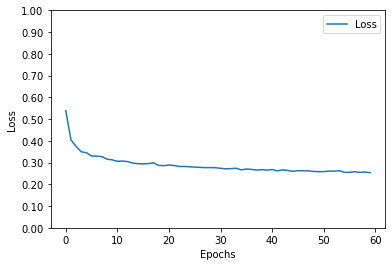

In [7]:
plot_object_detection_log_loss(no_od_model, "Loss tracking for job: " + no_od_model._current_job_name)